# An fMRI study of composition in noun and verb phrases
### Bonnasse-Gahot, Bemis, Perez-Guevara, Dehaene, Pallier
ROI analysis. (Re)producing Figure 7.

In [1]:
# coding: utf-8

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as op

import simpcomp as sc

from statsmodels.stats.anova import AnovaRM

import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

In [2]:
sns.set_style('darkgrid')

In [3]:
res_filename = op.join(sc.model_anova_folder, 'roi_analysis_model-anova.csv')
results = pd.read_csv(res_filename, index_col=0)

In [4]:
fig_filename = op.join(sc.figures_folder, 'roi_analysis_model-anova.pdf')

In [5]:
listofrois = ['IFGorb', 'TP', 'IFGtri', 'aSTS', 'IFGoper', 'pSTS', 'AG_TPJ']

In [6]:
position_in_figure = {'IFGorb':(0,0), 'IFGtri':(1,0), 'IFGoper':(2,0),
                      'TP':(0,1), 'aSTS':(1,1), 'pSTS':(2,1), 'AG_TPJ':(3,1)}

In [7]:
# removing the effects of Subject (see Cousineau, 2005)
def replace_mean_with_grand_mean(data, subject_list, listofrois):
    data_mod = []
    for roi_tmp in listofrois:
        data_mod_roi = data[data.ROI==roi_tmp].copy()
        grand_mean_tmp = np.mean(data_mod_roi.beta)
        for sub_id in subject_list:
            data_mod_roi.loc[data_mod_roi.subject==sub_id, 'beta'] = (
                data_mod_roi[data_mod_roi.subject==sub_id].beta
                - np.mean(data_mod_roi[data_mod_roi.subject==sub_id].beta)
                + grand_mean_tmp)
        data_mod.append(data_mod_roi)
    return pd.concat(data_mod)

results = replace_mean_with_grand_mean(results, sc.subject_list, listofrois)

In [8]:
def plot_stats_info(data, ax):
    # using Repeated Measures Anova
    anovarm = AnovaRM(data=data, depvar='beta', subject='subject', within=['seq_type', 'seq_length'])
    anovarmfit = anovarm.fit()
    p_tmp_t = anovarmfit.anova_table['Pr > F']['seq_type']
    t_significance = sc.pvalue2str(p_tmp_t)
    p_tmp_l = anovarmfit.anova_table['Pr > F']['seq_length']
    l_significance = sc.pvalue2str(p_tmp_l)
    p_tmp_tl = anovarmfit.anova_table['Pr > F']['seq_type:seq_length']
    tl_significance = sc.pvalue2str(p_tmp_tl)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    col = '0.1'
    axt1 = ax.text(-0.3,0.93*ylim[1],'seq_type'+' '+t_significance+' '+'({:.3f})'.format(p_tmp_t),
                   ha='left', va='center', color=col, fontsize=10)
    axt2 = ax.text(-0.3,0.84*ylim[1],'seq_length'+' '+l_significance+' '+'({:.3f})'.format(p_tmp_l),
                   ha='left', va='center', color=col, fontsize=10)
    x = xlim[0] + 0.67*(xlim[1] - xlim[0])
    h = 0.02*(xlim[1] - xlim[0])
    y1, y2 = 0.93*ylim[1], 0.85*ylim[1]
    ax.plot([x, x+h, x+h, x], [y1, y1, y2, y2], lw=1.5, c=col)
    ax.text(x+0.2,0.9*ylim[1],tl_significance+' '+'({:.3f})'.format(p_tmp_tl),
            ha='left', va='center', color=col, fontsize=10)

In [9]:
xlim = (-0.5, 3.5)
ylim = (-0.4, 1.1)

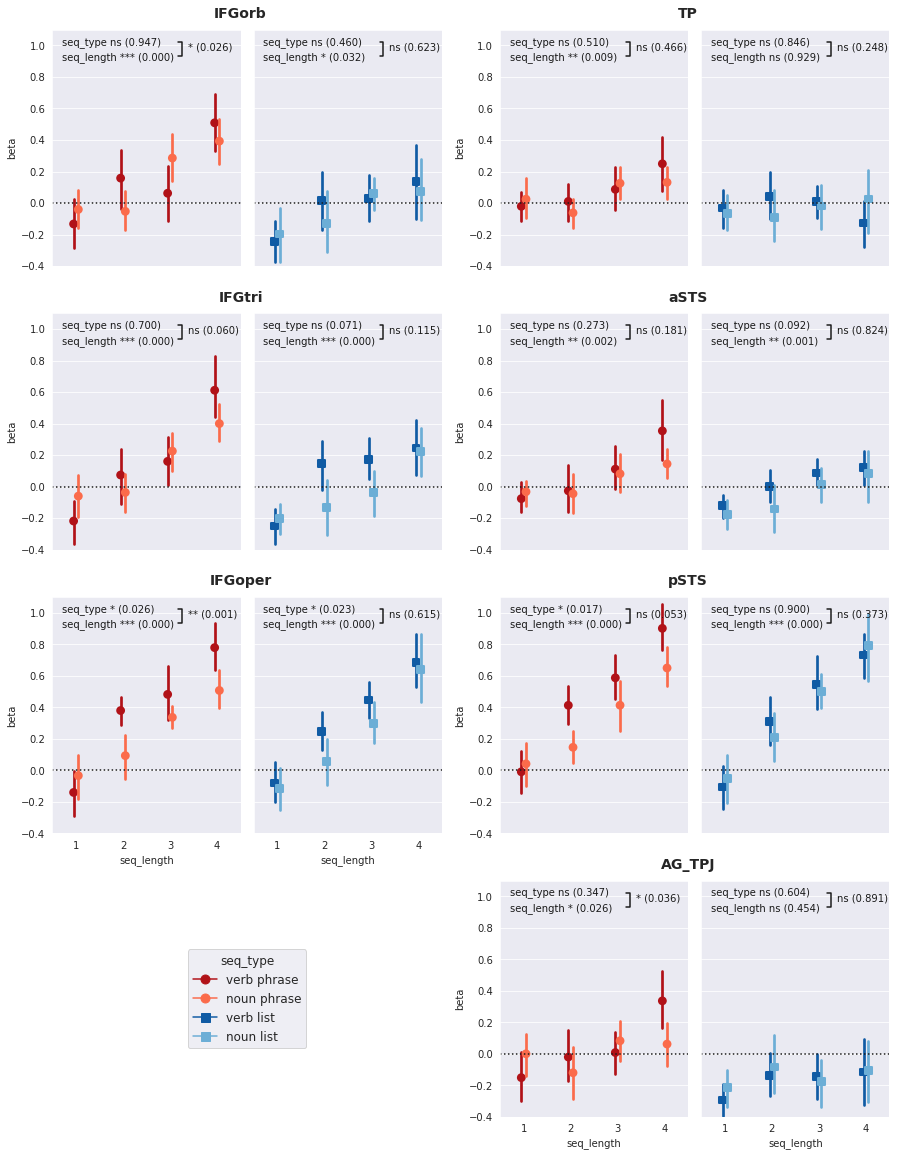

In [10]:
# Effect of Length in Regions of Interest
n_col = 2 
n_row = 4

fh = plt.figure()
fh.set_size_inches(15, 20)

gs = GridSpec(n_row, n_col, hspace=0.2, wspace=0.15, figure=fh)
gsk = []
for roi_tmp in listofrois:
    results_tmp = results[results.ROI==roi_tmp]

    gsk = GridSpecFromSubplotSpec(1, 2, 
                                 subplot_spec=gs[position_in_figure[roi_tmp][0], position_in_figure[roi_tmp][1]],
                                 wspace=0.07)
    
    ax = plt.subplot(gsk[0, 0])
    contrast_list = ['pv', 'pn']
    g = sns.pointplot(x='seq_length', y='beta', hue='seq_type',
                      data=results_tmp[np.isin(results_tmp.seq_type, contrast_list)],
                      ax=ax, dodge=0.1, 
                      join=False,
                      palette=sc.color[[0,2]], 
                      estimator=np.mean)
    ax.legend('')
    ax.get_legend().set_visible(False)
    ax.set(xlim=xlim, ylim=ylim)
    ax.axhline(0.0, ls=':', color='0.1')
    if roi_tmp not in ['IFGoper','AG_TPJ']:
        ax.set_xlabel('')
        ax.set_xticklabels('')
    plot_stats_info(results_tmp[np.in1d(results_tmp.seq_type, contrast_list)],
                    ax)
        
    ax.text(xlim[0] + 1.0*(xlim[1] - xlim[0]), ylim[0] + 1.05*(ylim[1] - ylim[0]), 
            roi_tmp, fontsize=14, fontweight='bold', ha='center')
    
    ax = plt.subplot(gsk[0, 1])
    contrast_list = ['lv', 'ln']
    g = sns.pointplot(x='seq_length', y='beta', hue='seq_type',
                      data=results_tmp[np.isin(results_tmp.seq_type, contrast_list)],
                      ax=ax, dodge=0.1, 
                      join=False,
                      palette=sc.color[[3,5]], 
                      markers='s',
                      estimator=np.mean)
    ax.legend('')
    ax.get_legend().set_visible(False)
    ax.set(xlim=xlim, ylim=ylim)
    ax.set_ylabel('')
    ax.set_yticklabels('')
    ax.axhline(0.0, ls=':', color='0.1')
    if roi_tmp not in ['IFGoper','AG_TPJ']:
        ax.set_xlabel('')
        ax.set_xticklabels('')
    plot_stats_info(results_tmp[np.in1d(results_tmp.seq_type, contrast_list)],
                    ax)

gsk = GridSpecFromSubplotSpec(1, 1, 
                         subplot_spec=gs[3, 0])
ax = plt.subplot(gsk[0, 0], frame_on=False, xticklabels=[], yticklabels=[])
darkred_marker = mlines.Line2D([], [], color=sc.color[0], marker='o', label='verb phrase',  markersize=9, linestyle=None)
lightred_marker = mlines.Line2D([], [], color=sc.color[2], marker='o', label='noun phrase',  markersize=9, linestyle=None)
darkblue_marker = mlines.Line2D([], [], color=sc.color[3], marker='s', label='verb list',  markersize=9, linestyle=None)
lightblue_marker = mlines.Line2D([], [], color=sc.color[5], marker='s', label='noun list',  markersize=9, linestyle=None)
plt.legend(handles=[darkred_marker, lightred_marker, darkblue_marker, lightblue_marker],
           bbox_to_anchor=(0.5, 0.5), 
           loc='center',
           title='seq_type', fontsize=12, title_fontsize=12)
plt.show()


fh.savefig(fig_filename, bbox_inches='tight')